# Notes

In this example, we aim to delve into the features learned through our pretraining process, with a focus on identifying the most significant types of features. Our exploration will first cover cell-level features, followed by an analysis of geneset-level features.

In [16]:
import sys
sys.path.insert(0, '/home/was966/Research/mims-responder/')
from responder.utils import plot_embed_with_label, score
from responder import PreTrainer, FineTuner, loadresponder

In [17]:
import os
from tqdm import tqdm
from itertools import chain
import pandas as pd
import numpy as np
import random, torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=1.5)

def onehot(S):
    assert type(S) == pd.Series, 'Input type should be pd.Series'
    dfd = pd.get_dummies(S, dummy_na=True)
    nanidx = dfd[dfd[np.nan]].index
    dfd.loc[nanidx, :] = np.nan
    dfd = dfd.drop(columns=[np.nan])*1.
    cols = dfd.sum().sort_values(ascending=False).index.tolist()
    dfd = dfd[cols]
    return dfd

In [18]:
# load the pretrained model as a feature extractor
pretrainer = loadresponder('./results/Pretrain_TCGA_tmb_20240116_220014/pretrainer.pt')
genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector
pretrainer.count_parameters()

80008

In [19]:
data_path = '/n/data1/hms/dbmi/zitnik/lab/users/was966/ITRP/TCGA-ITRP-GENESET-MERGE/1005/data'
df_label = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.PATIENT.TABLE'))
df_tpm = pd.read_pickle(os.path.join(data_path, 'ALL.ITRP.TPM.TABLE'))
df_tpm.shape, df_label.shape


((1188, 1005), (1188, 29))

In [20]:
df_label.cohort = df_label.cohort.apply(lambda x:x.split('_')[0])

In [21]:
cs = df_label.groupby('cohort').size().astype(str)
cs_map = pd.Series(cs.index + "(n=" + cs.values + ")", index=cs.index).to_dict()

In [22]:
df_label.cohort = df_label.cohort.map(cs_map)

In [23]:
celltype_features, y_random = pretrainer.predict(df_tpm,  batch_size= 128)

100%|##########| 10/10 [00:00<00:00, 14.02it/s]


In [24]:
celltype_feature_names = cellpathwayprojector.cellpathway_names
celltype_features.columns = celltype_feature_names
label = df_label['response_label']
cohort = df_label['cohort']
cancer = df_label['cancer_type']

In [25]:
from responder.dataloader import TCGAData, GeneData, ITRPData
from responder.model.model import Responder
import torch.utils.data as Torchdata

model = Responder(**pretrainer.saver.inMemorySave['model_args']) 
model.load_state_dict(pretrainer.saver.inMemorySave['model_state_dict'])
model = model.to(pretrainer.device)

model.eval()
df_tpm = pretrainer.scaler.transform(df_tpm)

genesetprojector = pretrainer.model.latentprojector.genesetprojector
cellpathwayprojector = pretrainer.model.latentprojector.cellpathwayprojector

predict_tcga = GeneData(df_tpm)
predict_loader = Torchdata.DataLoader(predict_tcga, 
                                      batch_size=128, 
                                      shuffle=False,
                                      pin_memory=True, 

                                      num_workers=4)
geneset_feat = []
celltype_feat = []
for anchor in tqdm(predict_loader, ascii=True):
    anchor = anchor.to('cuda')
    encoding = model.inputencoder(anchor)
    geneset_level_proj, cellpathway_level_proj = model.latentprojector(encoding)

    geneset_feat.append(geneset_level_proj)
    celltype_feat.append(cellpathway_level_proj)

genesetfeatures  = torch.concat(geneset_feat, axis=0).cpu().detach().numpy()
celltypefeatures = torch.concat(celltype_feat, axis=0).cpu().detach().numpy()

dfgeneset = pd.DataFrame(genesetfeatures, index = predict_tcga.patient_name, columns = genesetprojector.genesets_names)
dfcelltype = pd.DataFrame(celltypefeatures, index = predict_tcga.patient_name, columns = cellpathwayprojector.cellpathway_names)

100%|##########| 10/10 [00:00<00:00, 13.83it/s]


Text(233.25, 0.5, 'Cohort')

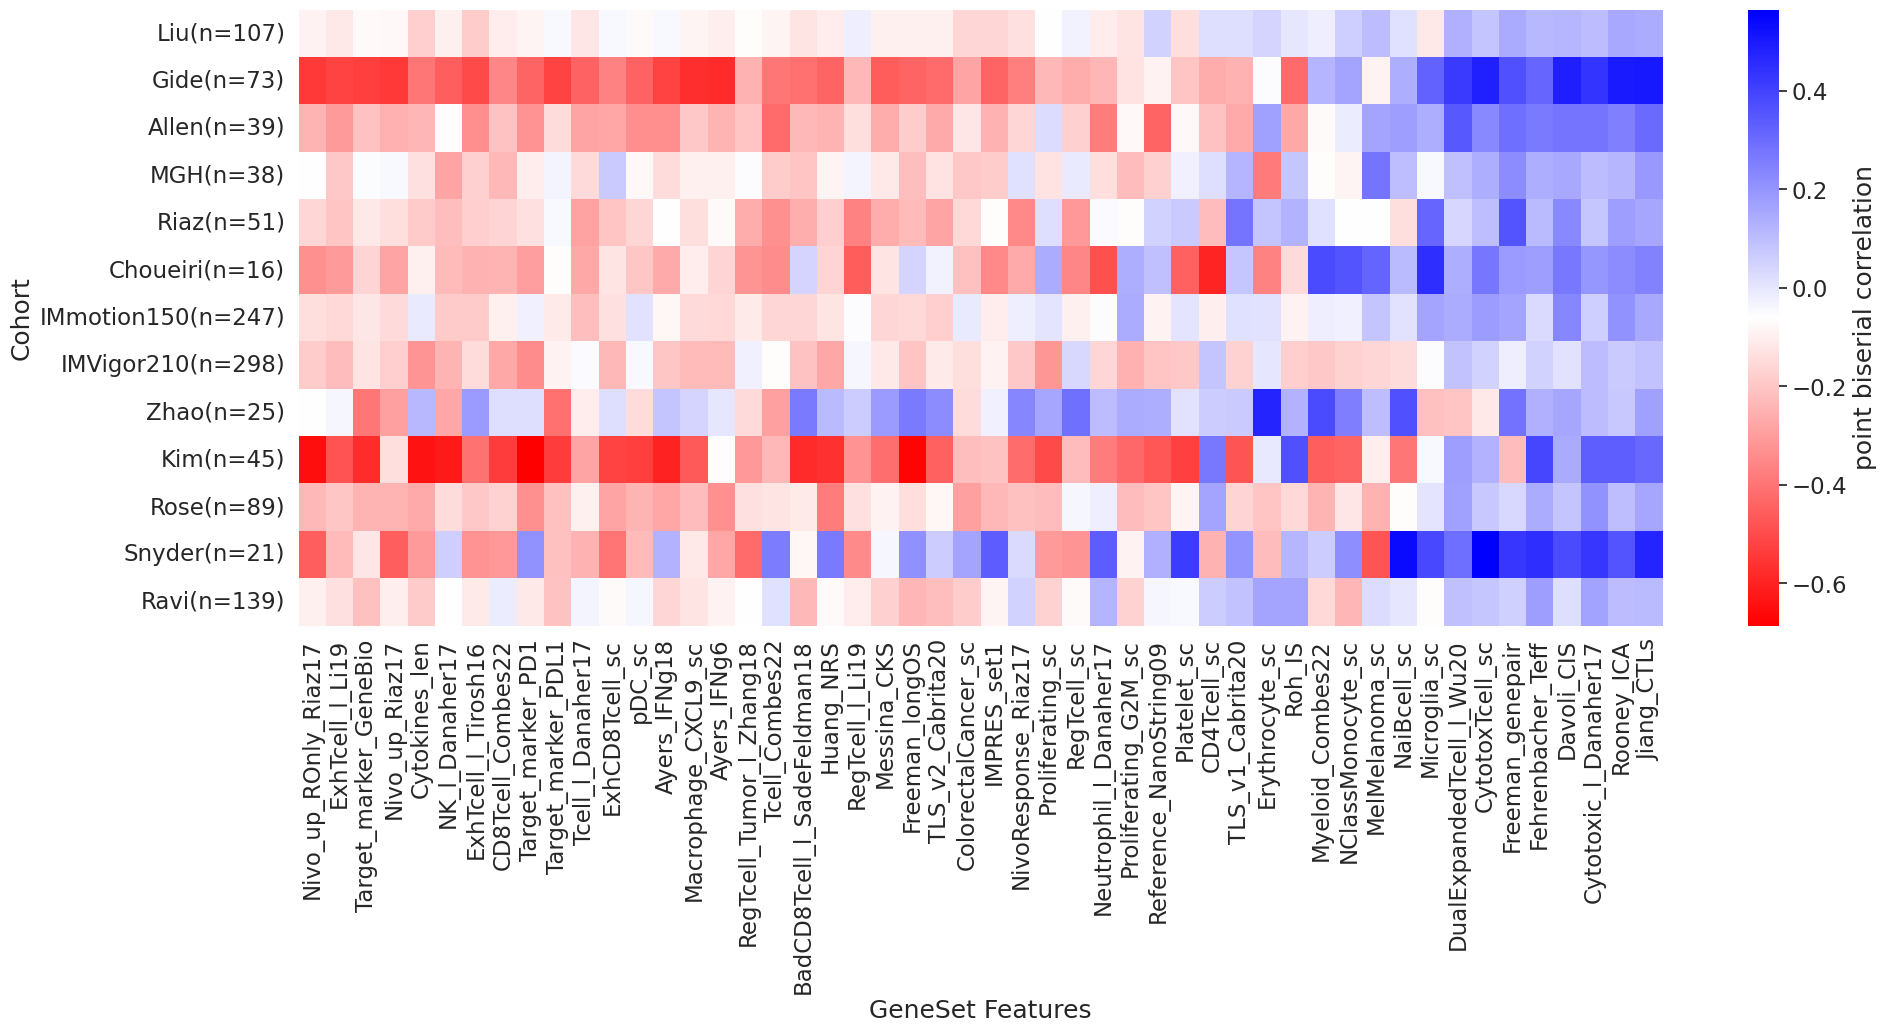

In [26]:
dfp = dfgeneset.join(label).join(cohort)

import scipy.stats as stats

res= []
for f in dfgeneset.columns:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[0])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
selected_geneset = pcc.abs().mean().sort_values().tail(50).index
pcc = pcc[selected_geneset]


pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[cohort.unique()]


fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(pcc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'})

# groups = df_label[['cancer_type', 'cohort']].drop_duplicates().groupby('cancer_type').cohort.apply(lambda x:x.tolist()).to_dict()
# annotate_yranges(groups, ax =ax)
  
ax.set_xlabel('GeneSet Features')
ax.set_ylabel('Cohort')

Text(233.25, 0.5, 'Cohort')

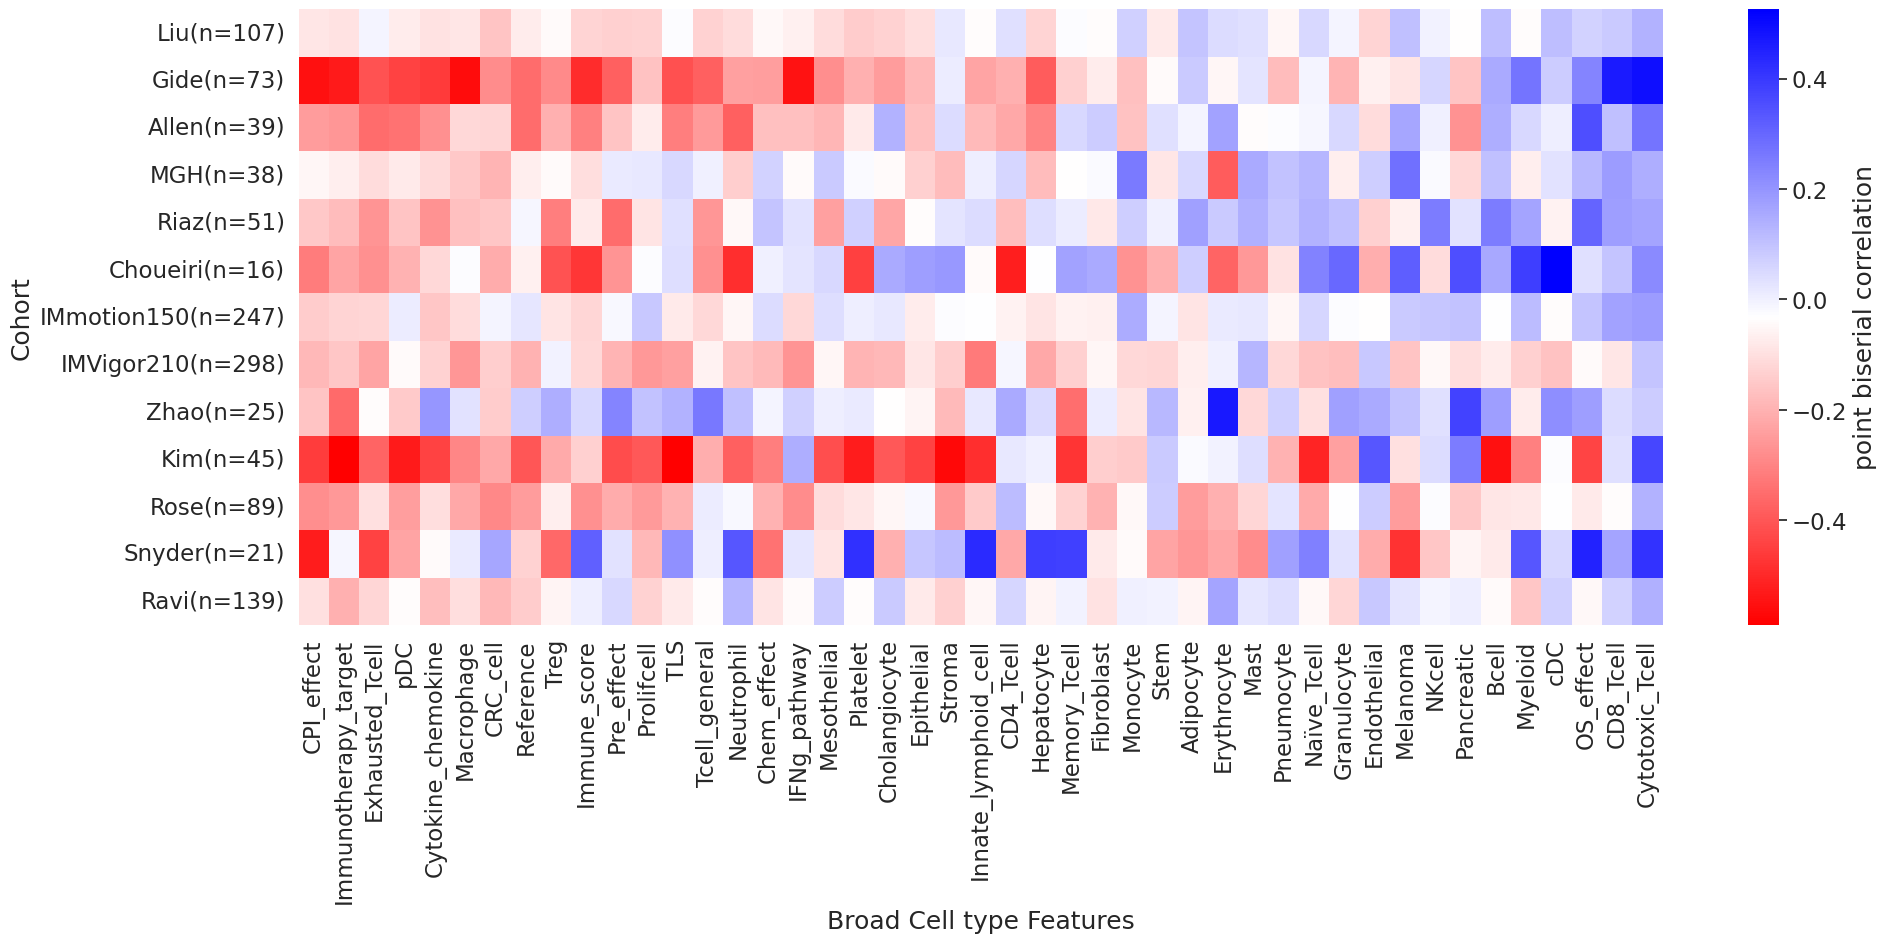

In [27]:
dfp = dfcelltype.join(label).join(cohort)

import scipy.stats as stats

res= []
for f in dfcelltype.columns:
    p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[0])
    p = p.to_frame(f)
    res.append(p)

pcc = pd.concat(res, axis=1)
pcc = pcc[pcc.mean().sort_values().index]
pcc = pcc.loc[cohort.unique()]

fig, ax = plt.subplots(figsize = (22,8))
sns.heatmap(pcc, cmap = 'bwr_r', ax=ax, cbar_kws={'label': 'point biserial correlation'})

# groups = df_label[['cancer_type', 'cohort']].drop_duplicates().groupby('cancer_type').cohort.apply(lambda x:x.tolist()).to_dict()
# annotate_yranges(groups, ax =ax)

ax.set_xlabel('Broad Cell type Features')
ax.set_ylabel('Cohort')

In [ ]:
# Adipocyte, Fibroblast, Melanoma, Malignant, Pancreaticxxxxx
# pcc['Epithelial']

In [ ]:
# res = []
# for f in celltype_feature_names:
#     p = dfp.groupby('cohort').apply(lambda x:stats.pointbiserialr(x.response_label.map({'R':1, 'NR':0}), x[f])[1])
#     p = p.to_frame(f)
#     res.append(p)

# pcc = pd.concat(res, axis=1)
# pcc = pcc[pcc.mean().sort_values().index]
# pcc = pcc.loc[pcc.mean(axis=1).sort_values().index]
# # pcc = 1.5**pcc
# fig, ax = plt.subplots(figsize = (22,4))
# sns.heatmap(pcc, cmap = 'rainbow', ax=ax, cbar_kws={'label': 'pvalue'})

# ax.set_xlabel('Broad Cell type Features')
# ax.set_ylabel('Cohort')

In [ ]:
# from statannot import add_stat_annotation
# for y in celltype_feature_names:
#     x = 'cohort'
#     hue = 'response_label'
#     data = dfp

#     fig, ax = plt.subplots(figsize = (10,4))
#     sns.violinplot(data = data, x=x, y=y, hue=hue, ax=ax)
#     ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#     ax.tick_params(bottom='on', left='off',  labelleft='on', labelbottom='on', pad=-.6,)
    
#     # add_stat_annotation(ax, data=data, x=x, y=y, hue=hue,
#     #                     box_pairs=[("R", "NR")],
#     #                     test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

In [ ]:
# w = cellpathwayprojector.cellpathway_aggregator.aggregator.attention_weights['cellpathway_30']
# idx = genesetprojector.GENESET.iloc[cellpathwayprojector.CELLPATHWAY.loc['Tcell']].index.to_list()
# Tcell_weights = pd.DataFrame(w.cpu().detach().numpy(),columns = ['attention weights'], index=idx)
# fig, ax = plt.subplots(figsize = (20,4))

# Tcell_weights.sort_values('attention weights').plot(kind='bar',ax=ax)
# ax.set_ylabel('Weights')
# ax.set_xlabel('Gene sets')
# plt.xticks(rotation=75, ha='right')